In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import numpy as np
from PIL import Image
import os
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
from random import randint

In [3]:
class DoubleConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv_operation = nn.Sequential(
            nn.Conv2d(in_channels=in_channels, out_channels=out_channels, kernel_size=3, stride=1, padding='same', bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.2),

            nn.Conv2d(in_channels=out_channels, out_channels=out_channels, kernel_size=3,  stride=1, padding='same', bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Dropout2d(0.2)
        )

    def forward(self, x):
        return self.conv_operation(x)

class DownSampling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.doubleconv = DoubleConv(in_channels=in_channels, out_channels=out_channels)
        # maxpooling membagi ukuran image jadi 2 kali lebih kecil atau setengahnya
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    def forward(self, x):
        down = self.doubleconv(x)
        pool = self.pool(down)
        # print(down.shape, pool.shape, "downsampling")
        return down, pool

class UpSampling(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.doubleconv = DoubleConv(in_channels=in_channels, out_channels=out_channels)
        # transpose convolution
        self.up = nn.ConvTranspose2d(in_channels=in_channels, out_channels=in_channels//2, kernel_size=2, stride=2)

    def crop_tensor(self, tensor, target_tensor):
        target_size = target_tensor.size()[2:]
        tensor_size = tensor.size()[2:]
        delta_h = tensor_size[0] - target_size[0]
        delta_w = tensor_size[1] - target_size[1]
        tensor = tensor[:, :, delta_h // 2:tensor_size[0] - delta_h // 2, delta_w // 2:tensor_size[1] - delta_w // 2]
        return tensor

    def forward(self, x1, x2):
        x1 = self.up(x1)
        x2 = self.crop_tensor(x2, x1)
        x = torch.cat([x2, x1], dim=1)
        return self.doubleconv(x)

class UNETModel(nn.Module):
    def __init__(self, in_channels=3, num_classes=1):
        super().__init__()
        self.down1 = DownSampling(in_channels, 64)
        self.down2 = DownSampling(64, 128)
        self.down3 = DownSampling(128, 256)
        self.down4 = DownSampling(256, 512)

        self.bottle_neck = DoubleConv(512, 1024)

        self.up1 = UpSampling(1024, 512)
        self.up2 = UpSampling(512, 256)
        self.up3 = UpSampling(256, 128)
        self.up4 = UpSampling(128, 64)

        self.finalConv = nn.Sequential(
            nn.Conv2d(64, num_classes, 1, 1),
            nn.Sigmoid()
        )


    def forward(self, x):
        down1, pool1 = self.down1(x)
        down2, pool2 = self.down2(pool1)
        down3, pool3 = self.down3(pool2)
        down4, pool4 = self.down4(pool3)

        bn = self.bottle_neck(pool4)

        up1 = self.up1(bn, down4)
        up2 = self.up2(up1, down3)
        up3 = self.up3(up2, down2)
        up4 = self.up4(up3, down1)

        return self.finalConv(up4)

In [4]:
class CustomDataset(Dataset):
    def __init__(self, root_path, num="full"):
        super().__init__()
        self.root_path = root_path
        if type(num) == int:
          self.images_path = sorted([f"{root_path}/images/{i}" for i in os.listdir(f"{root_path}/images")])[:num]
          self.masks_path = sorted([f"{root_path}/masks/{i}" for i in os.listdir(f"{root_path}/masks")])[:num]
        else:
          self.images_path = sorted([f"{root_path}/images/{i}" for i in os.listdir(f"{root_path}/images")])
          self.masks_path = sorted([f"{root_path}/masks/{i}" for i in os.listdir(f"{root_path}/masks")])

        self.transform = transforms.Compose([
            transforms.Resize((512, 512)),
            transforms.ToTensor()
        ])

    def __getitem__(self, index):
        image = Image.open(self.images_path[index]).convert('RGB')
        mask = Image.open(self.masks_path[index]).convert('L')
        mask = self.transform(mask)
        mask = ((mask > 0.1) * 1).float()

        return self.transform(image), mask

    def __len__(self):
        return len(self.images_path)

In [5]:
def trainOneEpoch(trainLoader, model, optimizer, criterion):
    model.train()
    train_running_loss = 0.0
    bpr = tqdm(enumerate(trainLoader), total=len(trainLoader), desc=f"loss: {train_running_loss}")
    for idx, data in bpr:
        optimizer.zero_grad()

        img = data[0].float().to(device)
        mask = data[1].float().to(device)
        pred = model(img)
        loss = criterion(pred, mask)

        train_running_loss += loss.item()
        bpr.set_description(f"loss: {train_running_loss / (idx + 1):.6f}")
        loss.backward()
        optimizer.step()

    return train_running_loss / len(trainLoader)

def testOneEpoch(testLoader, model, criterion, epoch):
    model.eval()
    test_running_loss = 0.0
    with torch.no_grad():
        bpr = tqdm(enumerate(testLoader), total=len(testLoader), desc=f"epoch: {epoch} loss: {test_running_loss}")
        for idx, data in bpr:
            img = data[0].float().to(device)
            mask = data[1].float().to(device)
            pred = model(img)
            loss = criterion(pred, mask)

            test_running_loss += loss.item()
            bpr.set_description(f"loss: {test_running_loss / (idx + 1):.6f}")

    return test_running_loss / len(testLoader)


In [21]:
def interface(idx, tuning_num=-2):
    img, msk = testSet.__getitem__(idx)
    pred = model(img.unsqueeze(0).float().to(device))
    pred_tunning = (pred > tuning_num) * 1

    print(torch.unique(pred), torch.unique(msk))

    pred = pred[0][0].cpu().detach().numpy()
    img_np = img[0].cpu().detach().numpy()
    msk = msk[0].cpu().detach().numpy()
    pred_tunning = pred_tunning[0][0].cpu().detach().numpy()

    print(pred.shape, msk.shape, img_np.shape, pred_tunning.shape)

    fig, axes = plt.subplots(1, 4, figsize=(15, 5))

    axes[0].imshow(img.permute(1, 2, 0))
    axes[0].set_title("image")

    axes[1].imshow(msk, cmap="gray")
    axes[1].set_title("mask")

    axes[2].imshow(pred, cmap="gray")
    axes[2].set_title("prediction")

    axes[3].imshow(pred_tunning, cmap="gray")
    axes[3].set_title("prediction tuning")

    plt.tight_layout()

    # Saving the figure
    save_path = f"/content/drive/MyDrive/ResultImage/BrainTumor/try-predict-{idx}.png"
    plt.savefig(save_path, bbox_inches='tight', dpi=300)
    print(f"Figure saved at {save_path}")

    plt.show()

In [7]:
test_path = "/content/drive/MyDrive/data/brain_tumor/test"
train_path = "/content/drive/MyDrive/data/brain_tumor/train"
manual_path = "/content/drive/MyDrive/data/brain_tumor/manual_test"

device = "cuda" if torch.cuda.is_available() else "cpu"
test_num = len(os.listdir("/content/drive/MyDrive/data/brain_tumor/test/images"))
train_num = len(os.listdir("/content/drive/MyDrive/data/brain_tumor/train/images"))
print("banyak train : ", train_num)
print("banyak test : ", test_num)
print("device: ", device)

banyak train :  1502
banyak test :  215
device:  cuda


In [8]:
testSet = CustomDataset(test_path)
trainSet = CustomDataset(train_path, num=900)

TrainLoader = DataLoader(trainSet, shuffle=True)
TestLoader = DataLoader(testSet, shuffle=True)

In [9]:
img, msk = testSet.__getitem__(0)
print(torch.unique(msk))

tensor([0., 1.])


In [10]:
model = UNETModel().to(device)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-5)

test_track_loss = []
train_track_loss = []

loss: 0.297928: 100%|██████████| 215/215 [00:21<00:00,  9.95it/s]


tensor([0.1534, 0.1536, 0.1537,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0',
       grad_fn=<Unique2Backward0>) tensor([0., 1.])
(512, 512) (512, 512) (512, 512) (512, 512)


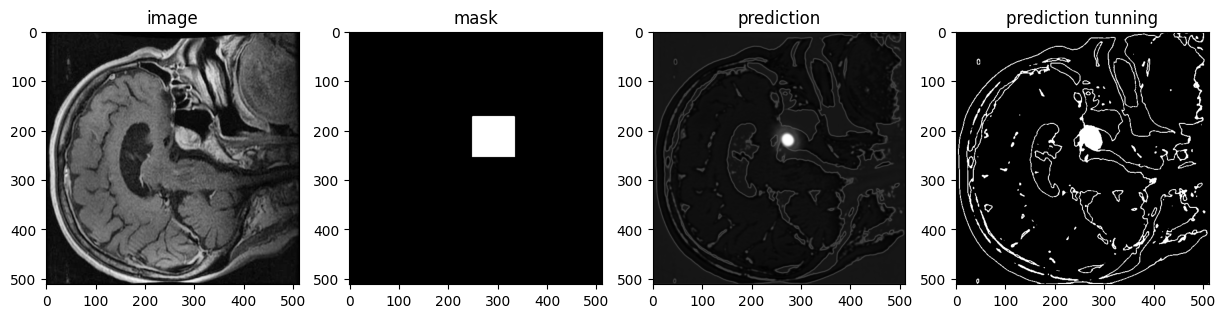

loss: 0.261701: 100%|██████████| 215/215 [00:22<00:00,  9.73it/s]


tensor([0.0992, 0.0993, 0.0993,  ..., 0.2996, 0.3003, 0.3015], device='cuda:0',
       grad_fn=<Unique2Backward0>) tensor([0., 1.])
(512, 512) (512, 512) (512, 512) (512, 512)


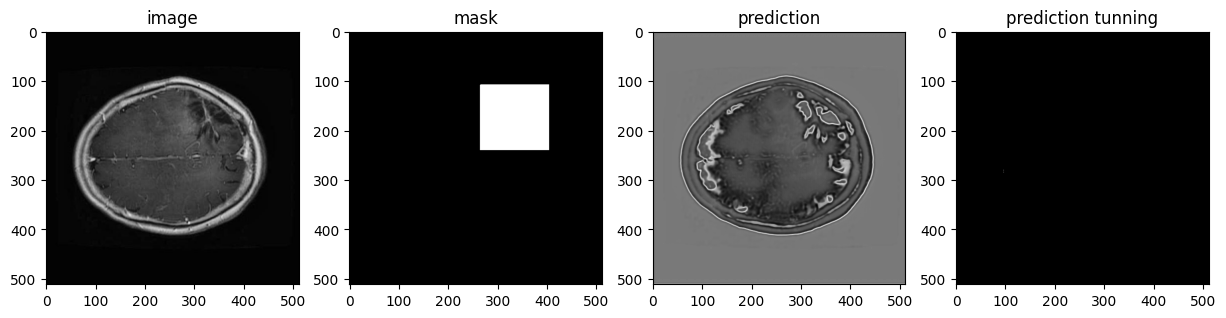

loss: 0.237582: 100%|██████████| 215/215 [00:22<00:00,  9.68it/s]


tensor([0.0964, 0.0971, 0.0975,  ..., 1.0000, 1.0000, 1.0000], device='cuda:0',
       grad_fn=<Unique2Backward0>) tensor([0., 1.])
(512, 512) (512, 512) (512, 512) (512, 512)


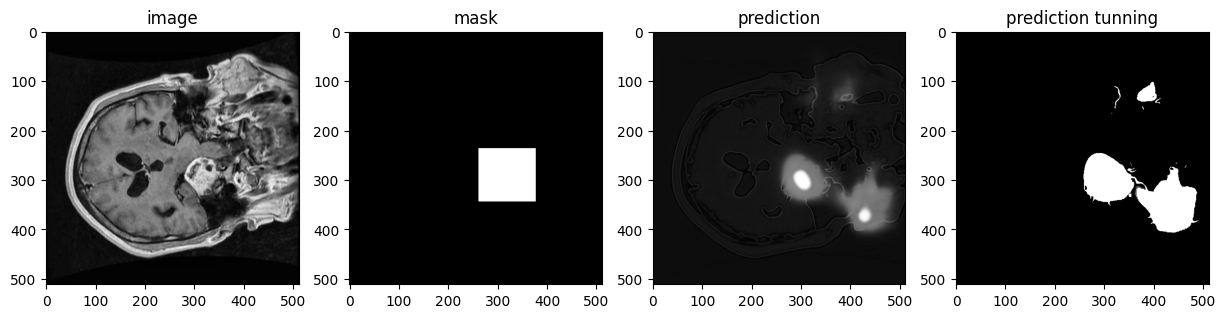

loss: 0.216588: 100%|██████████| 215/215 [00:22<00:00,  9.62it/s]


tensor([0.0707, 0.0709, 0.0720,  ..., 0.5200, 0.5201, 0.5210], device='cuda:0',
       grad_fn=<Unique2Backward0>) tensor([0., 1.])
(512, 512) (512, 512) (512, 512) (512, 512)


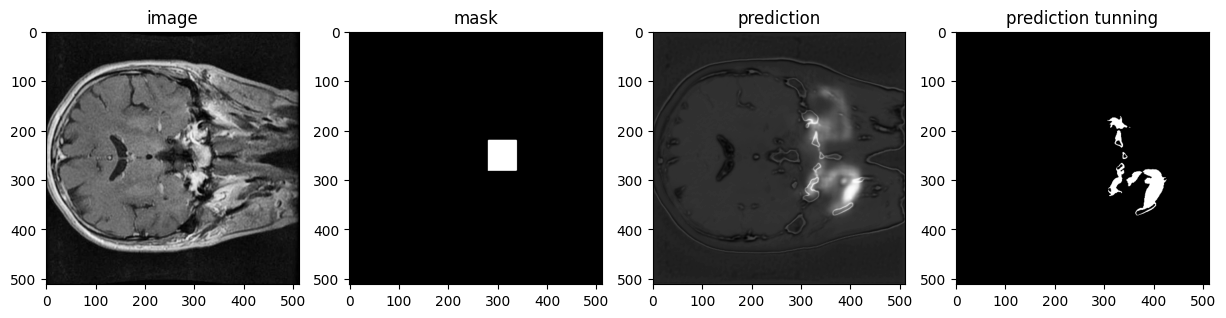

loss: 0.198931: 100%|██████████| 215/215 [00:22<00:00,  9.38it/s]


tensor([0.0832, 0.0835, 0.0842,  ..., 0.1855, 0.1855, 0.1863], device='cuda:0',
       grad_fn=<Unique2Backward0>) tensor([0., 1.])
(512, 512) (512, 512) (512, 512) (512, 512)


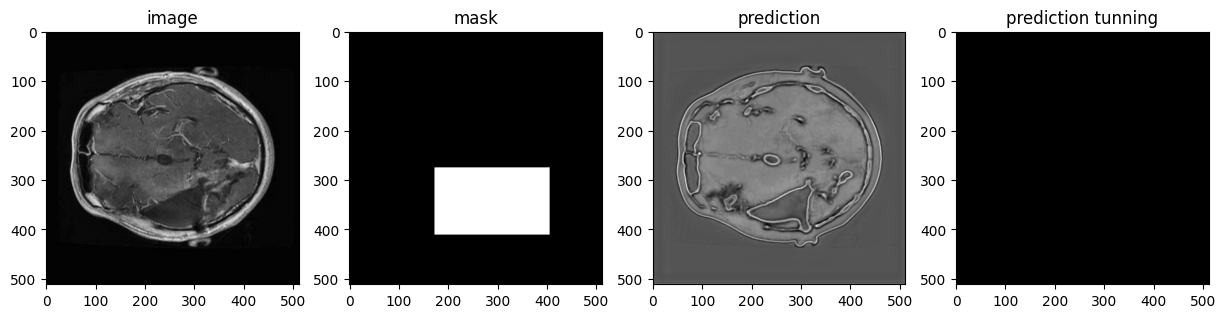

loss: 0.176450: 100%|██████████| 215/215 [00:22<00:00,  9.42it/s]


tensor([0.0579, 0.0590, 0.0603,  ..., 0.8525, 0.8535, 0.8537], device='cuda:0',
       grad_fn=<Unique2Backward0>) tensor([0., 1.])
(512, 512) (512, 512) (512, 512) (512, 512)


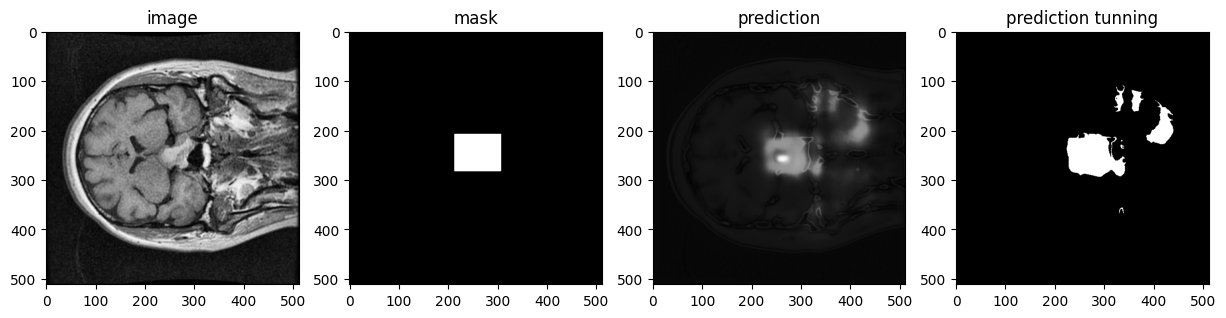

loss: 0.169962: 100%|██████████| 215/215 [00:23<00:00,  9.33it/s]


tensor([0.0545, 0.0547, 0.0553,  ..., 0.1845, 0.1861, 0.1878], device='cuda:0',
       grad_fn=<Unique2Backward0>) tensor([0., 1.])
(512, 512) (512, 512) (512, 512) (512, 512)


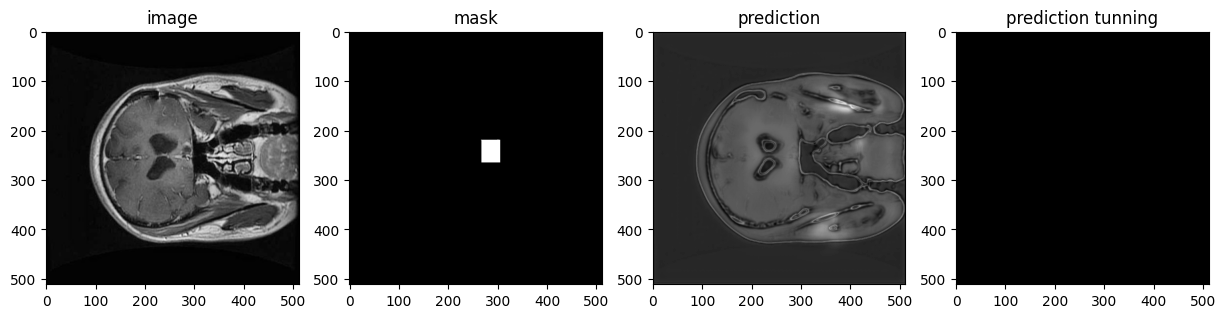

loss: 0.156282: 100%|██████████| 215/215 [00:23<00:00,  9.29it/s]


tensor([0.0458, 0.0461, 0.0462,  ..., 0.2844, 0.2888, 0.2923], device='cuda:0',
       grad_fn=<Unique2Backward0>) tensor([0., 1.])
(512, 512) (512, 512) (512, 512) (512, 512)


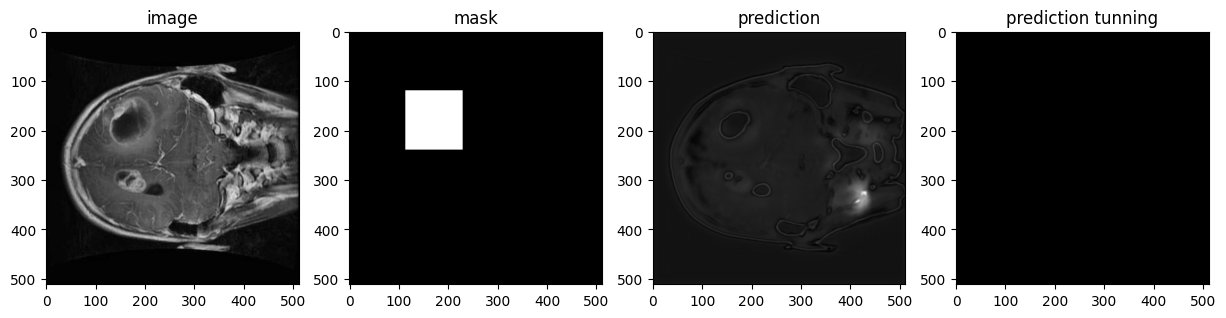

loss: 0.150896: 100%|██████████| 215/215 [00:23<00:00,  9.31it/s]


tensor([0.0317, 0.0318, 0.0326,  ..., 0.0960, 0.0962, 0.0976], device='cuda:0',
       grad_fn=<Unique2Backward0>) tensor([0., 1.])
(512, 512) (512, 512) (512, 512) (512, 512)


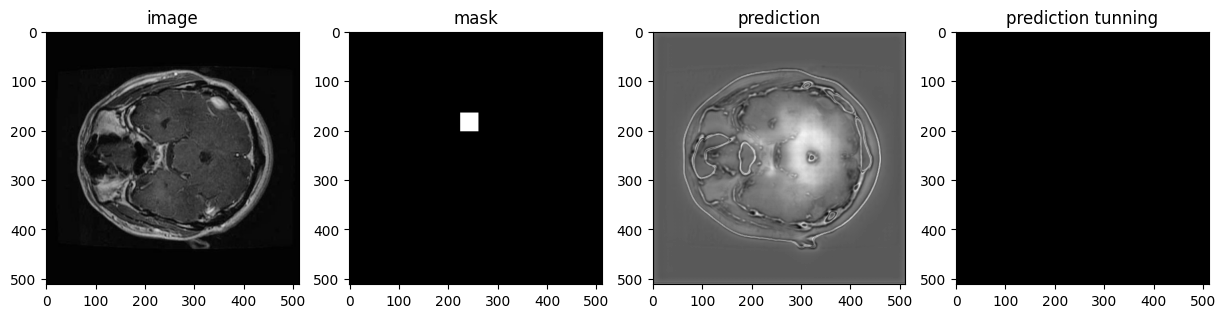

loss: 0.143325: 100%|██████████| 215/215 [00:23<00:00,  9.28it/s]


tensor([0.0320, 0.0321, 0.0321,  ..., 0.1782, 0.1802, 0.1803], device='cuda:0',
       grad_fn=<Unique2Backward0>) tensor([0., 1.])
(512, 512) (512, 512) (512, 512) (512, 512)


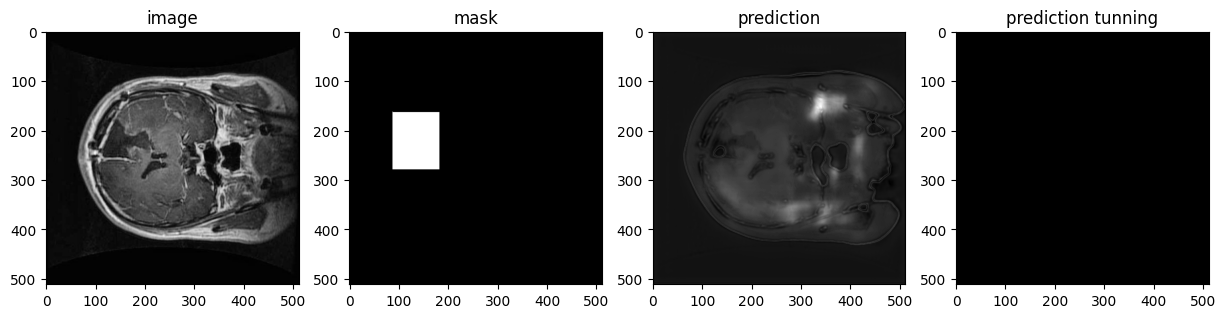

In [12]:
for epoch in range(10):
    train_loss = trainOneEpoch(TrainLoader, model, optimizer, criterion)
    test_loss = testOneEpoch(TestLoader, model, criterion, epoch)
    test_track_loss.append(test_loss)
    train_track_loss.append(train_loss)
    interface(randint(0, test_num - 1), 0.3)

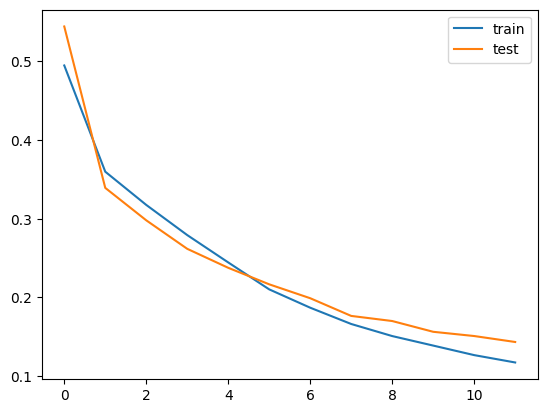

In [13]:
plt.plot(train_track_loss, label="train")
plt.plot(test_track_loss, label="test")
plt.legend()
plt.show()

In [14]:
torch.save(model.state_dict(), "/content/drive/MyDrive/model/brain_tumor/model3.pt")

tensor([0.0313, 0.0320, 0.0329,  ..., 0.6959, 0.7009, 0.7087], device='cuda:0',
       grad_fn=<Unique2Backward0>) tensor([0., 1.])
(512, 512) (512, 512) (512, 512) (512, 512)


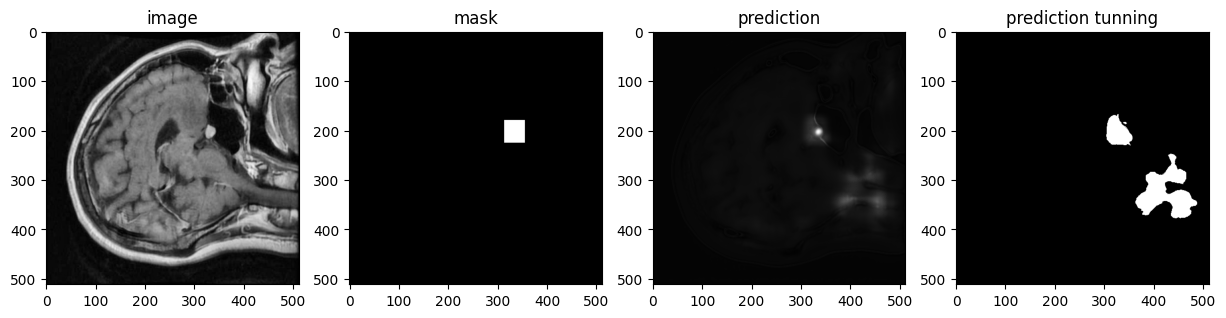

In [18]:
interface(
    idx=randint(0, test_num-1),
    tuning_num=0.1
)

tensor([0.0342, 0.0352, 0.0354,  ..., 0.5089, 0.5101, 0.5128], device='cuda:0',
       grad_fn=<Unique2Backward0>) tensor([0., 1.])
(512, 512) (512, 512) (512, 512) (512, 512)
Figure saved at /content/drive/MyDrive/ResultImage/BrainTumor/try-predict-56.png


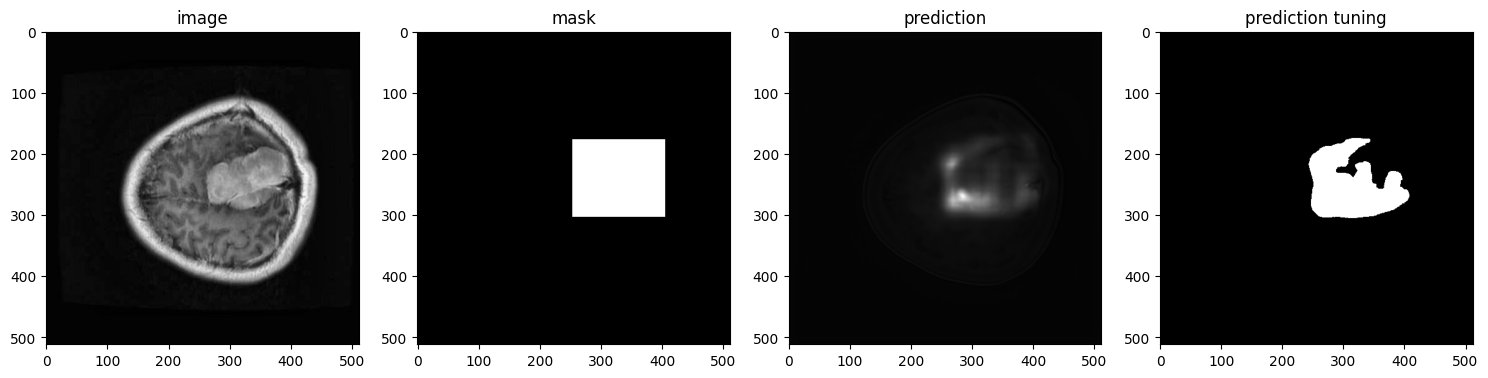

tensor([0.0341, 0.0344, 0.0350,  ..., 0.8860, 0.8863, 0.8878], device='cuda:0',
       grad_fn=<Unique2Backward0>) tensor([0., 1.])
(512, 512) (512, 512) (512, 512) (512, 512)
Figure saved at /content/drive/MyDrive/ResultImage/BrainTumor/try-predict-68.png


<Figure size 640x480 with 0 Axes>

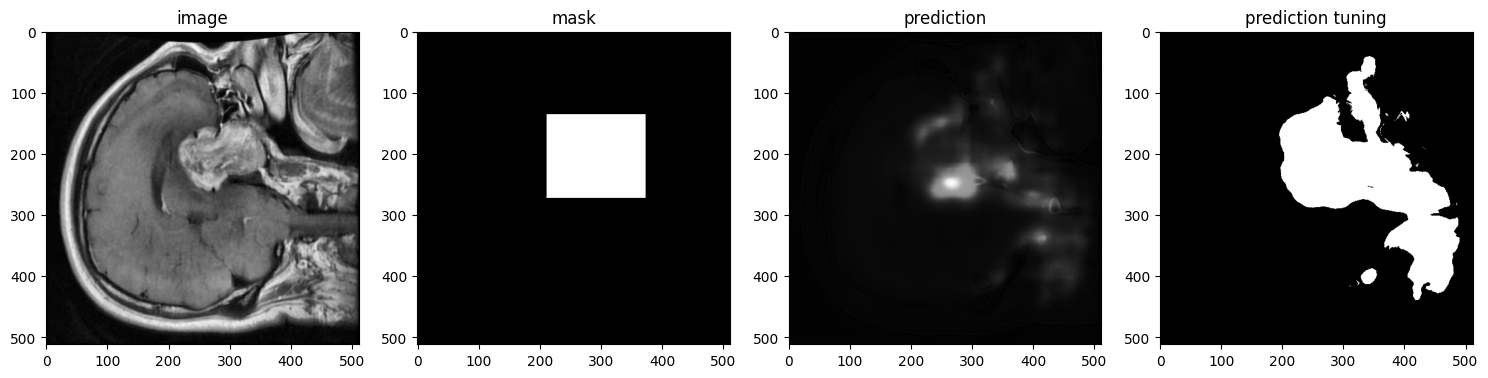

tensor([0.0322, 0.0324, 0.0330,  ..., 0.5459, 0.5467, 0.5472], device='cuda:0',
       grad_fn=<Unique2Backward0>) tensor([0., 1.])
(512, 512) (512, 512) (512, 512) (512, 512)
Figure saved at /content/drive/MyDrive/ResultImage/BrainTumor/try-predict-126.png


<Figure size 640x480 with 0 Axes>

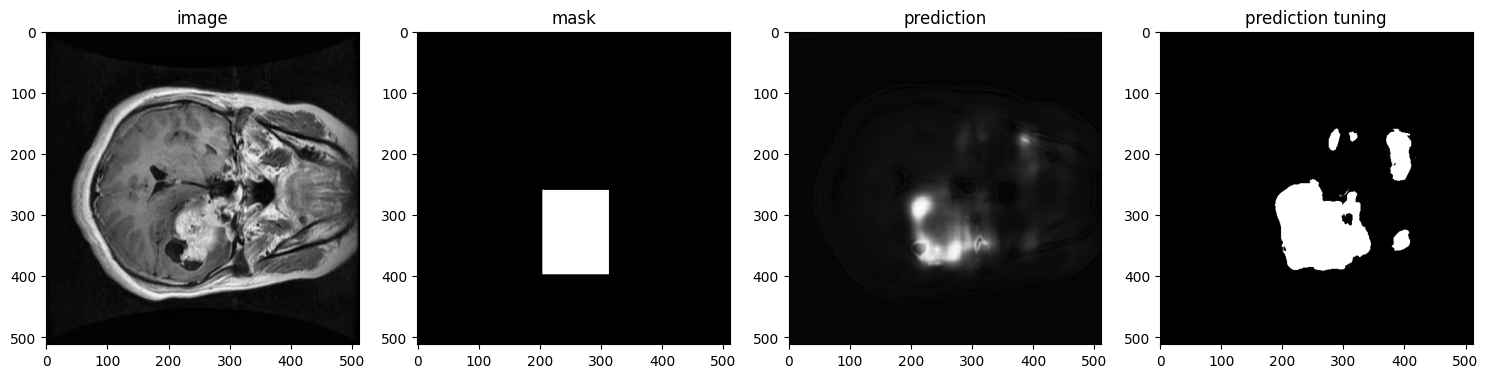

tensor([0.0342, 0.0346, 0.0348,  ..., 0.6516, 0.6545, 0.6607], device='cuda:0',
       grad_fn=<Unique2Backward0>) tensor([0., 1.])
(512, 512) (512, 512) (512, 512) (512, 512)
Figure saved at /content/drive/MyDrive/ResultImage/BrainTumor/try-predict-113.png


<Figure size 640x480 with 0 Axes>

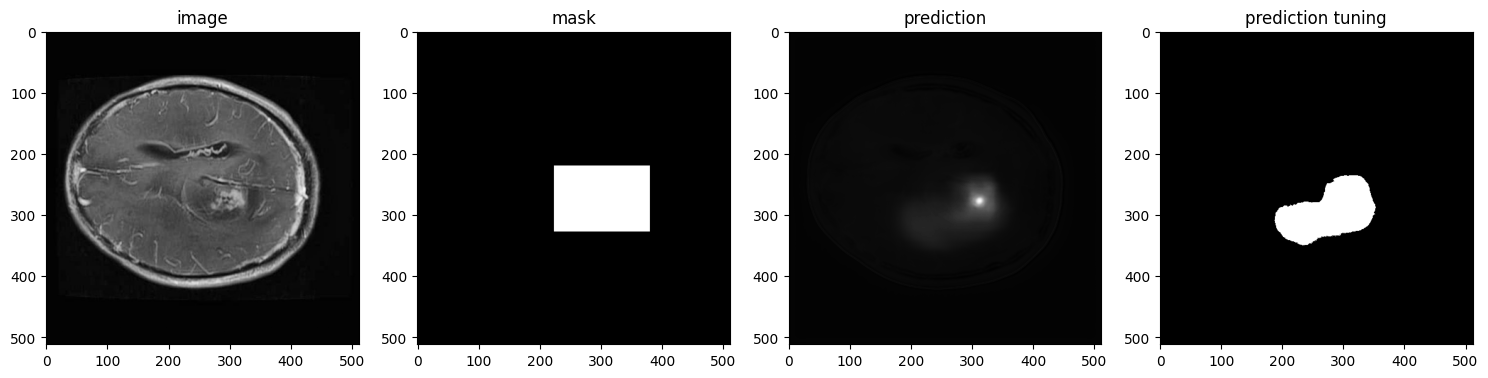

tensor([0.0292, 0.0297, 0.0297,  ..., 0.5141, 0.5149, 0.5159], device='cuda:0',
       grad_fn=<Unique2Backward0>) tensor([0., 1.])
(512, 512) (512, 512) (512, 512) (512, 512)
Figure saved at /content/drive/MyDrive/ResultImage/BrainTumor/try-predict-155.png


<Figure size 640x480 with 0 Axes>

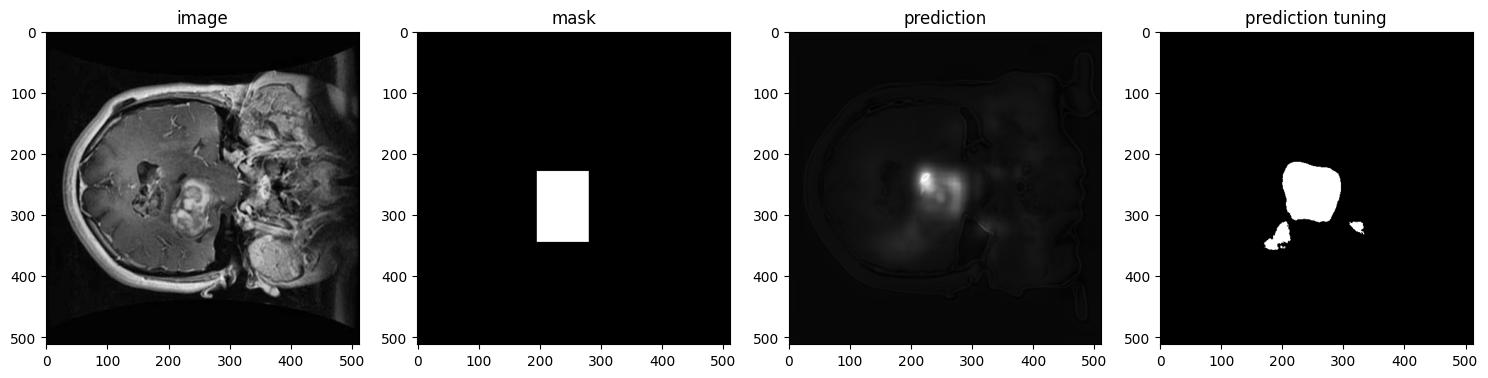

tensor([0.0276, 0.0290, 0.0301,  ..., 0.4915, 0.4930, 0.4966], device='cuda:0',
       grad_fn=<Unique2Backward0>) tensor([0., 1.])
(512, 512) (512, 512) (512, 512) (512, 512)
Figure saved at /content/drive/MyDrive/ResultImage/BrainTumor/try-predict-30.png


<Figure size 640x480 with 0 Axes>

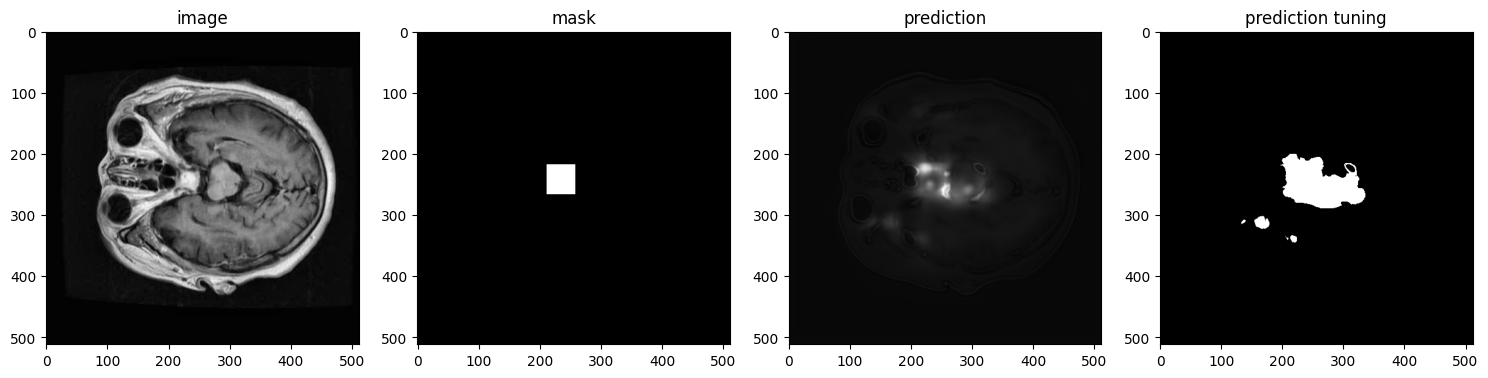

tensor([0.0318, 0.0319, 0.0320,  ..., 0.9478, 0.9482, 0.9492], device='cuda:0',
       grad_fn=<Unique2Backward0>) tensor([0., 1.])
(512, 512) (512, 512) (512, 512) (512, 512)
Figure saved at /content/drive/MyDrive/ResultImage/BrainTumor/try-predict-70.png


<Figure size 640x480 with 0 Axes>

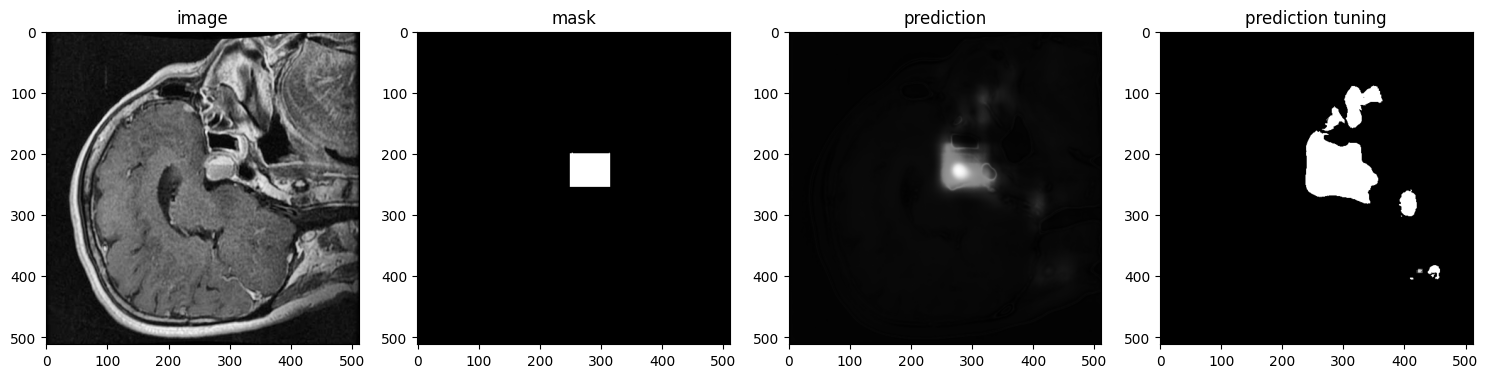

tensor([0.0320, 0.0320, 0.0321,  ..., 0.6645, 0.6707, 0.6747], device='cuda:0',
       grad_fn=<Unique2Backward0>) tensor([0., 1.])
(512, 512) (512, 512) (512, 512) (512, 512)
Figure saved at /content/drive/MyDrive/ResultImage/BrainTumor/try-predict-144.png


<Figure size 640x480 with 0 Axes>

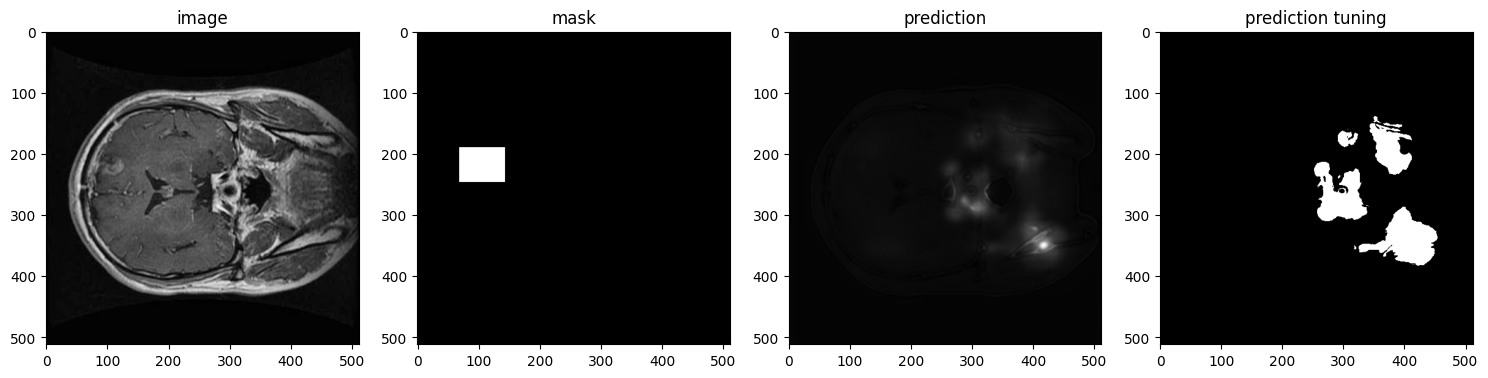

tensor([0.0326, 0.0326, 0.0328,  ..., 0.2452, 0.2453, 0.2457], device='cuda:0',
       grad_fn=<Unique2Backward0>) tensor([0., 1.])
(512, 512) (512, 512) (512, 512) (512, 512)
Figure saved at /content/drive/MyDrive/ResultImage/BrainTumor/try-predict-119.png


<Figure size 640x480 with 0 Axes>

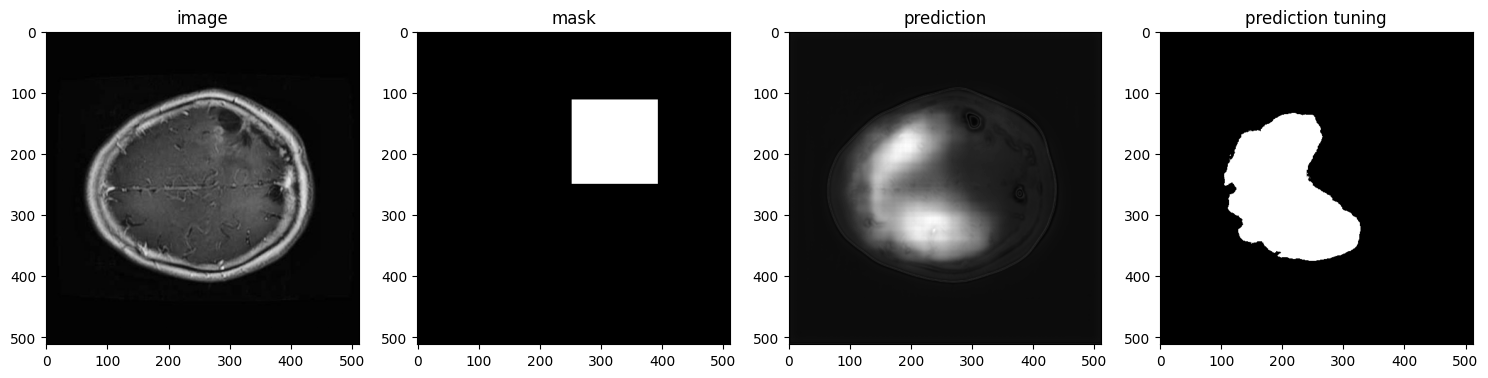

tensor([0.0310, 0.0311, 0.0314,  ..., 0.3007, 0.3037, 0.3043], device='cuda:0',
       grad_fn=<Unique2Backward0>) tensor([0., 1.])
(512, 512) (512, 512) (512, 512) (512, 512)
Figure saved at /content/drive/MyDrive/ResultImage/BrainTumor/try-predict-152.png


<Figure size 640x480 with 0 Axes>

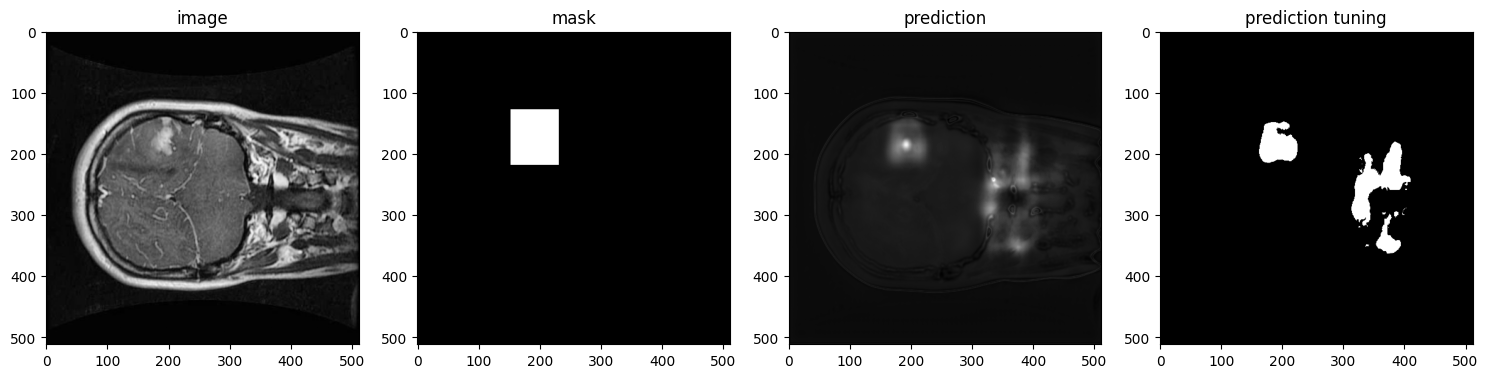

<Figure size 640x480 with 0 Axes>

In [22]:
for i in range(10):
  interface(
    idx=randint(0, test_num-1),
    tuning_num=0.1
  )
  plt.savefig(f"random-try-{i+1}.png")